In [3]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import glob
import re
from matplotlib import colors
import json

#for event display
import sys
#path to event display directory - change with where your path is 
sys.path.append("/afs/cern.ch/user/l/lcook")
from WCTE_event_display.EventDisplay import EventDisplay
import matplotlib.colors as colors

## Load in the data

Loading in the file, we can configure how many entries to load in. In the jupyer notebook all entries are loaded into memory so loading too many can cause issues. entry_start=0 and entry_stop=10000 can be altered to load more or less entries. It can also help to only load certain branches (such as all branches except the waveforms which contain the most data)

In [4]:
file_path = "/eos/experiment/wcte/data/2025_commissioning/processed_offline_data/production_v0_5/1406/WCTE_offline_R1406S0_VME_matched.root"
with uproot.open(file_path) as root_file:
    tree = root_file["WCTEReadoutWindows"]
    branches_to_load = ["window_time"]
    all_events = tree.arrays(entry_start=0,entry_stop=10000,library="ak")    
    
    # to load specific branches only e.g.
    # branches_to_load = ["window_time"]
    # all_events = tree.arrays(entry_start=0,entry_stop=10000,filter_name=branches_to_load,library="ak")

To see the branches in the file

In [5]:
print(all_events[0].fields)

['window_time', 'start_counter', 'run_id', 'sub_run_id', 'spill_counter', 'event_number', 'readout_number', 'trigger_types', 'trigger_times', 'led_gains', 'led_dacsettings', 'led_ids', 'led_card_ids', 'led_slot_numbers', 'led_event_types', 'led_types', 'led_sequence_numbers', 'led_counters', 'hit_mpmt_card_ids', 'hit_pmt_channel_ids', 'hit_mpmt_slot_ids', 'hit_pmt_position_ids', 'hit_pmt_charges', 'hit_pmt_times', 'pmt_waveform_mpmt_card_ids', 'pmt_waveform_pmt_channel_ids', 'pmt_waveform_mpmt_slot_ids', 'pmt_waveform_pmt_position_ids', 'pmt_waveform_times', 'pmt_waveforms', 'beamline_pmt_qdc_charges', 'beamline_pmt_tdc_times', 'beamline_pmt_qdc_ids', 'beamline_pmt_tdc_ids', 'window_data_quality', 'hit_pmt_calibrated_times', 'hit_pmt_readout_mask']


Load the metadata json to see a list of stable channels for the run. The channels are stored as a single integer defined as 100*mPMT_slot_id + pmt_position_id. This will be more useful later for comparisons to simulation. Other information here is the revision number of the timing constants and when they were inserted to the database, the run number and run configuration.

In [7]:
file_path = "/eos/experiment/wcte/data/2025_commissioning/processed_offline_data/production_v0_5/1406/run_1406_meta_data_json.json"

with open(file_path, "r") as f:
    metadata = json.load(f)
print(metadata.keys())

good_mpmt_channel_list = metadata["good_wcte_pmts"]
print(len(good_mpmt_channel_list),"wcte PMTs stably readout during the run")

print("The run configuration is",metadata["run_configuration"] )

dict_keys(['run_number', 'run_configuration', 'good_wcte_pmts', 'wcte_pmts_with_timing_constant', 'wcte_pmts_slow_control_stable', 'timing_constant_revision_id', 'timing_constant_insert_time'])
1556 wcte PMTs stably readout during the run
The run configuration is Good_mpmt_beam_v36


## Run configuration

The full run configuration for each run was saved in the online DAQ run and configuration database, this database has been dumped to json for ease of access on lxplus

You can explore the run configuration to get the window size, configuration of the RBU and configuration of each of the mPMTs


In [11]:
run_configuration_name = metadata["run_configuration"] 
config_file_path = "/eos/experiment/wcte/configuration/tooldaq_run_configs/configurations.json"
with open(config_file_path, 'r') as f:
    config_data = json.load(f)
run_config = config_data[run_configuration_name]

print(run_config['device_configs'].keys())

#e.g to get the window times
print("Window pre-trigger (in CC)",run_config['device_configs']['WCTE_RBU']['WindowBuilder']['main_pre_trigger'])
print("Window post-trigger (in CC)",run_config['device_configs']['WCTE_RBU']['WindowBuilder']['main_post_trigger'])

dict_keys(['MPMT1', 'MPMT3', 'MPMT6', 'MPMT7', 'MPMT8', 'MPMT10', 'MPMT11', 'MPMT12', 'MPMT14', 'MPMT15', 'MPMT16', 'MPMT17', 'MPMT18', 'MPMT19', 'MPMT20', 'MPMT21', 'MPMT22', 'MPMT23', 'MPMT24', 'MPMT25', 'MPMT26', 'MPMT27', 'MPMT28', 'MPMT29', 'MPMT30', 'MPMT31', 'MPMT32', 'MPMT33', 'MPMT34', 'MPMT35', 'MPMT36', 'MPMT38', 'MPMT40', 'MPMT41', 'MPMT42', 'MPMT43', 'MPMT44', 'MPMT45', 'MPMT46', 'MPMT47', 'MPMT48', 'MPMT52', 'MPMT71', 'MPMT73', 'MPMT74', 'MPMT75', 'MPMT76', 'MPMT77', 'MPMT78', 'MPMT79', 'MPMT80', 'MPMT82', 'MPMT83', 'MPMT84', 'MPMT85', 'MPMT86', 'MPMT87', 'MPMT89', 'MPMT91', 'MPMT92', 'MPMT93', 'MPMT94', 'MPMT96', 'MPMT97', 'MPMT98', 'MPMT99', 'MPMT100', 'MPMT101', 'MPMT102', 'MPMT103', 'MPMT104', 'MPMT105', 'MPMT106', 'MPMT107', 'MPMT108', 'MPMT109', 'MPMT111', 'MPMT112', 'MPMT113', 'MPMT114', 'MPMT115', 'MPMT117', 'MPMT118', 'MPMT130', 'MPMT131', 'MPMT132', 'WCTE_RBU'])
Window pre-trigger (in CC) 300
Window post-trigger (in CC) 50


In [9]:
## Verify in the data that the window size of the event is correct
trigger_times = []
hit_times = [] 

for event in all_events:
    #the trigger time of the main trigger
    trigger_times.append(event['trigger_times'][event['trigger_types']==3][0])

    hit_times.extend(event['hit_pmt_times'])


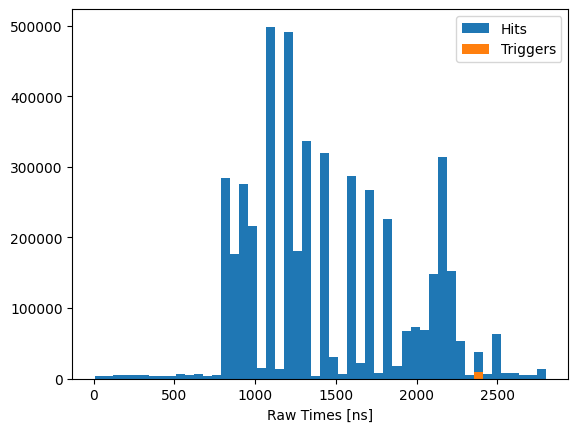

In [10]:
_, bins,_ = plt.hist(hit_times,bins =50, label = "Hits")
plt.hist(trigger_times, bins =bins, label = "Triggers")
plt.xlabel("Raw Times [ns]")
plt.legend()

## Timing calibration applied

So far we have plotted the raw hit timing, the files processed for the workshop have timing constants applied
If we plot the calibrated hit times we should expect the hits to arrive at similar time


Text(0.5, 0, 'Calibrated Times [ns]')

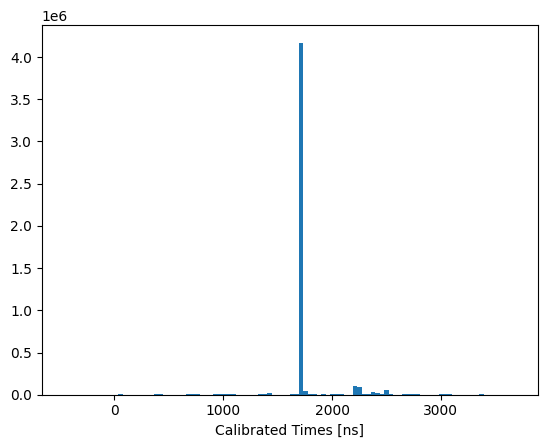

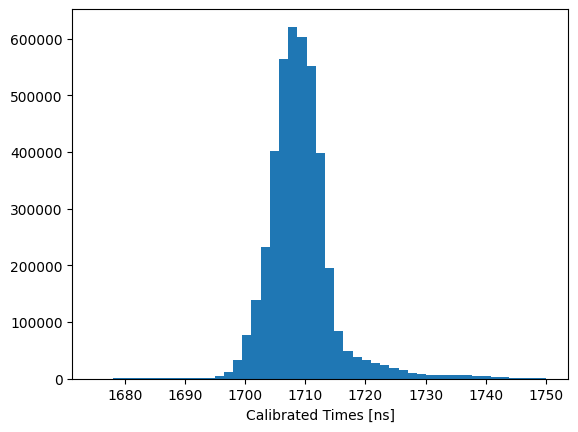

In [33]:
hit_pmt_calibrated_times = ak.flatten(all_events["hit_pmt_calibrated_times"])
plt.hist(hit_pmt_calibrated_times, bins =100)
plt.xlabel("Calibrated Times [ns]")
plt.show

plt.figure()
plt.hist(hit_pmt_calibrated_times, bins =np.linspace(1675,1750))
plt.xlabel("Calibrated Times [ns]")


Note that these are the times w.r.t the window start (which is with reference to the trigger signal which is on an 8ns clock cycle), 
the beam particle is not phaselocked to that 8ns clock (it can arrive anywhere within that 8ns clock cycle) and so there is a spread in times seen in this distribution. To produce a narrower time distribution we would need to subtract the timing from the beam monitor signal read in through the trigger mainboards. Dean has an example of this here: https://github.com/WCTE/mpmt_teststand/blob/main/jupyter/explore_wcte_root_dict.ipynb 



If we plot on a log scale we can see the bunch structure of our beam. Bunches in the beam are separated by ~300ns. Essentially where another particle enters the detector in the same window. 


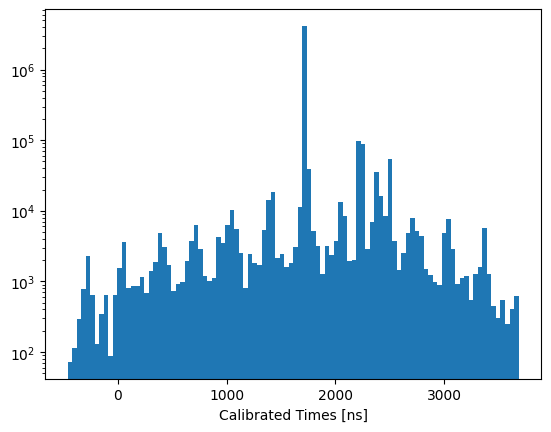

In [13]:
plt.hist(hit_pmt_calibrated_times, bins =100)
plt.xlabel("Calibrated Times [ns]")
plt.yscale("log")

## Data quality flags

#### 1) Window level flags
Limited data quality flags have been applied to the data based on known periods of readout failure. window_data_quality branch contains a flag for potential problems. 0= no potential problems found, 1= trigger effected by 67ms issue, 2= slow control data quality issues identified (e.g. dropped packets)

In [14]:
data_quality = [] 
window_times = [] 
for event in all_events:
    data_quality.append(event["window_data_quality"])
    window_times.append(event["window_time"])

window_times = np.array(window_times)

Text(0, 0.5, 'Window time % 2^26 ns')

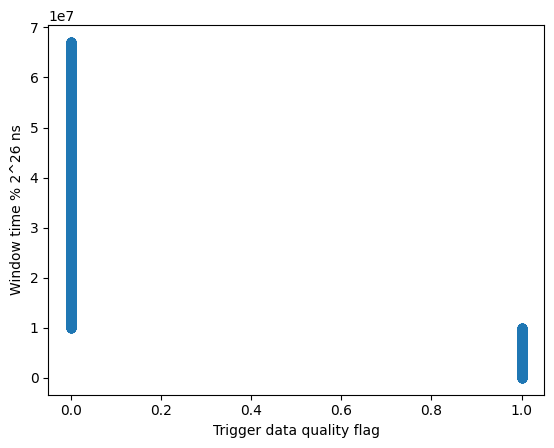

In [15]:
plt.scatter(data_quality,window_times%(2**26))
plt.xlabel("Trigger data quality flag")
plt.ylabel("Window time % 2^26 ns")

#### 2) Channel level flags
Flags have been applied to individual hits based on slow control data and availability of calibration constants for each channel. The channel mask is the same for all triggers in the run and defined as a bitmask 0= no potential problems found, 1= no calibration constant for channel issue, 2= slow control data quality issues

In [17]:
#e.g. look at the first 20 events and look at the number of hits which pass selection cuts
for ievent, event in enumerate(all_events[:20]):
    if (event['window_data_quality']!=0):
        print("Event excluded with flag",event['window_data_quality'])
        continue
    
    nhits = len(event['hit_pmt_times'])
    trigger_mainboard_hits = np.sum(event['hit_mpmt_card_ids']>120) # for trigger mainboards 130,131,132
    wcte_pmt_hits = np.sum((event['hit_mpmt_card_ids']<120))
    wcte_pmt_hits_pass_mask = np.sum((event['hit_mpmt_card_ids']<120) & (event['hit_pmt_readout_mask']==0))

    print("trigger_mainboard_hits",trigger_mainboard_hits,"wcte_pmt_hits",wcte_pmt_hits,"wcte_pmt_hits pass channel selection",wcte_pmt_hits_pass_mask)

Event excluded with flag 1
trigger_mainboard_hits 26 wcte_pmt_hits 575 wcte_pmt_hits pass channel selection 573
trigger_mainboard_hits 31 wcte_pmt_hits 594 wcte_pmt_hits pass channel selection 591
trigger_mainboard_hits 27 wcte_pmt_hits 304 wcte_pmt_hits pass channel selection 304
trigger_mainboard_hits 30 wcte_pmt_hits 555 wcte_pmt_hits pass channel selection 554
trigger_mainboard_hits 29 wcte_pmt_hits 603 wcte_pmt_hits pass channel selection 602
trigger_mainboard_hits 28 wcte_pmt_hits 437 wcte_pmt_hits pass channel selection 435
trigger_mainboard_hits 30 wcte_pmt_hits 293 wcte_pmt_hits pass channel selection 292
Event excluded with flag 1
trigger_mainboard_hits 23 wcte_pmt_hits 561 wcte_pmt_hits pass channel selection 559
trigger_mainboard_hits 44 wcte_pmt_hits 82 wcte_pmt_hits pass channel selection 80
trigger_mainboard_hits 28 wcte_pmt_hits 552 wcte_pmt_hits pass channel selection 550
trigger_mainboard_hits 29 wcte_pmt_hits 560 wcte_pmt_hits pass channel selection 557
trigger_mainb

## Event display

Data quality flag 0
(2014,)


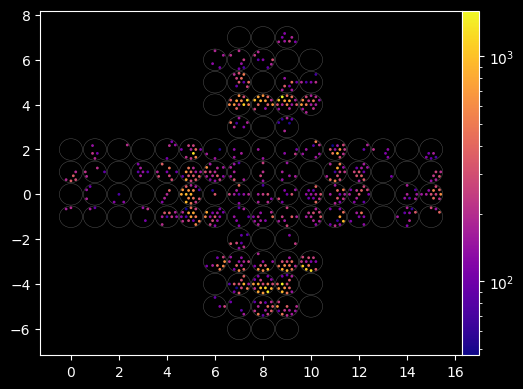

In [27]:
sys.path.append("/afs/cern.ch/user/l/lcook")
import importlib
import WCTE_event_display.EventDisplay

importlib.reload(WCTE_event_display.EventDisplay)

from WCTE_event_display.EventDisplay import EventDisplay

#create an instance of event diplay class
eventDisplay = EventDisplay() 
#load the positions of the mPMTs (an internal file to the event display class that 
#specificies where to plot and what orientation to plot mPMTs on the event display)
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')

#e.g. select a single event randomly
event = all_events[20]
print("Data quality flag",event['window_data_quality'])

#apply a mask to hits, don't include hits labelled as bad or hits on trigger mainboards in the event display
hit_mask = (event['hit_pmt_readout_mask']==0) & (event['hit_mpmt_card_ids']<120)

pmt_slot = event['hit_mpmt_slot_ids'][hit_mask]
pmt_pos = event['hit_pmt_position_ids'][hit_mask]
data_to_plot  = event['hit_pmt_charges'][hit_mask]

#this function processes pmt positions and the data to plot into an array for use by the event display
#sum_data will sum data for the same channel e.g. if a channel has 2 hits in event['hit_pmt_charges'] they will be summed
#if summed data is false it will by default take the smallest value for each channel for plotting time distributions
ev_disp_data = eventDisplay.process_data(pmt_slot,pmt_pos,data_to_plot,sum_data=True)

#this pltos the event display, colors.Normalize() will plot on a linear scale
eventDisplay.plotEventDisplay(ev_disp_data,color_norm=colors.LogNorm(), style= "dark_background")

#optional ability to draw the mPMT slot id for each mPMT
# eventDisplay.label_mPMTs(np.arange(0,106))

plt.show(block=False)
plt.style.use('default') 


We can apply an additional timing cut to the hits based on the hit tim distribution above to reduce backgrounds

Data quality flag 0
(2014,)


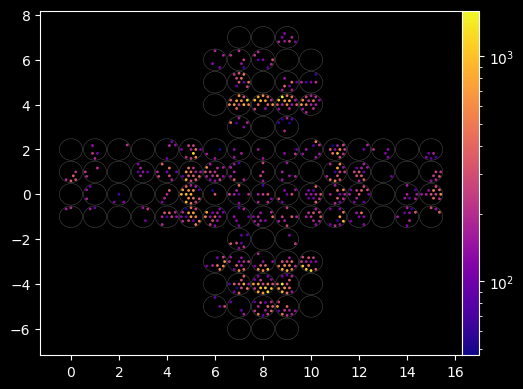

In [35]:
event = all_events[20]
print("Data quality flag",event['window_data_quality'])

#apply a mask to hits, don't include hits labelled as bad or hits on trigger mainboards in the event display
hit_mask = (event['hit_pmt_readout_mask']==0) & (event['hit_mpmt_card_ids']<120) &( event["hit_pmt_calibrated_times"]>1690)&(event["hit_pmt_calibrated_times"]<1750)

pmt_slot = event['hit_mpmt_slot_ids'][hit_mask]
pmt_pos = event['hit_pmt_position_ids'][hit_mask]
data_to_plot  = event['hit_pmt_charges'][hit_mask]

ev_disp_data = eventDisplay.process_data(pmt_slot,pmt_pos,data_to_plot,sum_data=True)
eventDisplay.plotEventDisplay(ev_disp_data,color_norm=colors.LogNorm(), style= "dark_background")
plt.show(block=False)
plt.style.use('default') 


We could also make a cumulative event display for e.g. the first 20 events

(2014,)


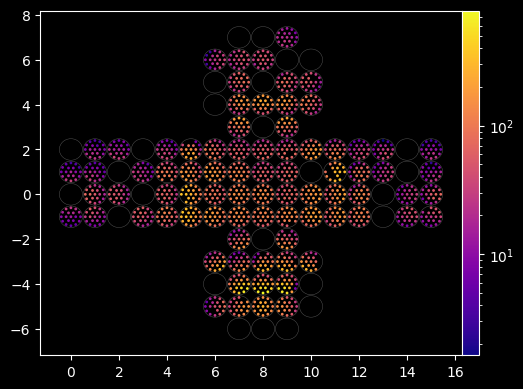

In [36]:

nEvents = 0 
pmt_slot = []
pmt_pos = []
data_to_plot = []

for event in all_events[:1000]:
    #filter out windows which fail the data quality checks 
    if event['window_data_quality']!=0:
        continue
    nEvents+=1
    
    hit_mask = (event['hit_pmt_readout_mask']==0) & (event['hit_mpmt_card_ids']<120)
    
    pmt_slot.extend(event['hit_mpmt_slot_ids'][hit_mask])
    pmt_pos.extend(event['hit_pmt_position_ids'][hit_mask])
    data_to_plot.extend(event['hit_pmt_charges'][hit_mask])

ev_disp_data = eventDisplay.process_data(pmt_slot,pmt_pos,data_to_plot,sum_data=True)
#average by each event
ev_disp_data = ev_disp_data/nEvents 
eventDisplay.plotEventDisplay(ev_disp_data,color_norm=colors.LogNorm(), style= "dark_background")
plt.show(block=False)
plt.style.use('default')


## Excercise
Using the beam selection code from yesterday integrate this into the code processing the WCTE data, apply a selection to WCTE data to make distribtions of total charge, number of hits and event displays for each particle species. Should be able to identify that electrons will produce the most light in the detector, followed my muons then pions. These distributions will be used as the starting point for data to monte carlo comparisons. Muons or protons in higher energy runs will be useful for these comparisons. 